In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.cm as cm

def plot_setup():
    plt.rcParams['text.usetex'] = False
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    plt.rcParams['mathtext.fontset'] = 'cm'
    # plt.rcParams['figure.autolayout'] = 'True'

    sns.set_style('ticks',{'axes.edgecolor': '[0,0,0]',
                           'xtick.direction':'in',
                           'ytick.direction':'in',
                           'ytick.right':'True',
                           'xtick.top':'True',
                           'xtick.color':'k',
                           'ytick.color':'k'
                            })

def diffusion(size,sigma,mu):
    gamma_m = 6*np.pi*0.3*0.01
    gamma = 6*np.pi*mu*0.005*size
    return ((sigma/(gamma_m+gamma))**2)/2

def plus(n,kplus,dt):
    return kplus*dt

def minus(n,kminus,dt):
    return kminus*dt

def on(n,kon0,kon1,dt):
    return (kon0+kon1*(n-1))*dt

def off(n,koff0,koff1,dt):
    return koff0*dt

def Model1ABM(sigma,mu,num):
    #run an instance of the agent-based model to simulate 1 PAR-3 cluster
    #njit will automatically deal with the random number seeds so that each
    #python instance will get it's own random number (so that the results aren't the same for each core when running in parallel)
    #
    # Set up parameters
    #
    x0 = 0
    y0 = 0
    t0 = 0
    tend = num
    dt = 0.001
    tgrid = np.arange(t0,tend+dt,dt)
    kplus = 0.05
    kminus = 0.1
    kon0 = 0
    kon1 = 0
    koff0 = 0
    koff1 = 0
    m = 2
    vc = np.zeros(m)
    vc[0] = 0
    #
    # Set up initial condtions, and initialize storage vectors
    #
    x = np.empty(tgrid.size)
    y = np.empty(tgrid.size)
    x[0] = x0
    y[0] = y0
    n = np.empty(tgrid.size)
    n[0] = np.random.randint(low=1,high=(10+1)) #random size between 1 and 10 at t0
    b = np.empty(tgrid.size)
    b[0] = 0
    #
    # time loop
    #
    for i in range(1,tgrid.size):
        #update diffusion
        D = diffusion(n[i-1],sigma,mu)
        #update position
        x[i] = x[i-1] + vc[0]*dt + np.sqrt(2*D*dt)*np.random.randn()
        y[i] = y[i-1] + vc[1]*dt + np.sqrt(2*D*dt)*np.random.randn()
        #
        # Calculate reaction probabilities (calls functions for the size dependent reaction rates)
        #
        probs = np.array([plus(n[i-1],kplus,dt),minus(n[i-1],kminus,dt),on(n[i-1],kon0,kon1,dt),off(n[i-1],koff0,koff1,dt)]) #vector of probabilities
        # these reactions are thus indexed by rxn = 0, 1, 2, 3
        #
        #Determine which reaction occurs for this time step
        #
        r = np.random.rand() #draw a random number
        j = 0 #reaction index
        p_sum = 0.0 #running total of probabilities
        while p_sum < r:
            #while the running total is less than the random number
            if j == 4: #if we've gone through all the reactions,
                j = 5  #increase j by 1
                break  #quit the loop
            #add the probabilitiy
            p_sum += probs[j] #add the next reaction's probability
            j+= 1 #increase index by 1
        #THUS, j-1 is the index of the reaction to do
        rxn = j-1
        if rxn == 0:
            #kplus
            n[i] = n[i-1]+1 #increase size by 1
            b[i] = b[i-1] #binding state does not change
        elif rxn == 1:
            #kminus
            if n[i-1] == 1: #if the size decreses by 1, but there is only one monomer, then do nothing
                n[i] = n[i-1]
                b[i] = b[i-1]
            else:
                n[i] = n[i-1]-1 #decrease size by 1
                b[i] = b[i-1] #binding state does not change
        elif rxn == 2:
            #kon
            n[i] = n[i-1] #size does not change
            b[i] = 1 #boolean variable: bound!
        elif rxn == 3:
            #koff
            n[i] = n[i-1] #size does not change
            b[i] = 0 #boolean variable: unbound!
        elif rxn == 4:
            #do nothing
            n[i] = n[i-1]
            b[i] = b[i-1]
        else:
            break
            print('Error in reactions')
    #
    # data storage
    #
    tint = 1000 #delta_t_analysis (1000 * 0.001 s = 1 seconds)
    data = np.empty((len(tgrid[::tint]),4)) #store trajectory in a matrix of size (...x4)
    #... time points, corresponding to t = 0,1,2,3,...,480
    data[:,0] = x[::tint] #x coord in first column
    data[:,1] = y[::tint] #y coord in second column
    data[:,2] = n[::tint] #size in third column
    data[:,3] = b[::tint] #bound/unbound in fourth column

    return data


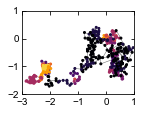

In [7]:
np.random.seed(42)
plot_setup()

num_cells = 1

sigma = 0.01 #noise level
mu = np.random.uniform(0.05,0.5,num_cells) #drag

vc = np.array([0,0])
num_t = 501 #8 minutes int of timesteps
ncols = 4
num = num_t - 1


data = np.empty((num_cells,num_t,ncols))
for i in range(num_cells):
    data[i] = Model1ABM(sigma,mu[i],num)

M = 10
cmap=cm.get_cmap('inferno',M)
fig, ax = plt.subplots(1,1,figsize=(2,3))
ax.plot(data[i,:,0],data[i,:,1],'-',lw=0.5,color=[0.4,0.4,0.4],zorder=1)
ax.scatter(data[i,:,0],data[i,:,1],s=4,c=data[i,:,2],cmap=cmap,vmin=1-0.5,vmax=M+0.5,zorder=2)
ax.set_aspect('equal')
ax.set_xlim((-3,1))
ax.set_ylim((-2,1))
ax.set_xticks(np.arange(-3,2))
fig.savefig('figures/Fig1_Traj.pdf',format='pdf')
